In [66]:
import os
os.chdir("/exp/sbnd/app/users/svidales/AI_nuvT")

In [67]:
from imports import *

## Import data

In [68]:
import pyarrow as pa
import pyarrow.parquet as pq
import awkward as ak

# Cargar archivo Parquet
table = pq.read_table("/exp/sbnd/app/users/svidales/AI_nuvT/v1305_tpcselection_preproc_springval_allevents_50energylimit.parquet")

# Convertir de Arrow Table a awkward Array
data_loaded = {name: ak.from_arrow(column) for name, column in zip(table.column_names, table.columns)}

# Acceder a las variables cargadas
nuvT = data_loaded["nuvT"]
#f_ophit_PE = data_loaded["f_ophit_PE"]
#f_ophit_ch = data_loaded["f_ophit_ch"]
#f_ophit_t = data_loaded["f_ophit_t"]
dEpromx = data_loaded["dEpromx"]
dEpromy = data_loaded["dEpromy"]
dEpromz = data_loaded["dEpromz"]

### Creation of PE matrix

In [6]:
# Create matrices to store the number of photoelectrons and times for each event and channel
pe_matrix = np.zeros((len(f_ophit_ch), 312))

# Populate the matrices
for i in range(len(f_ophit_ch)):
    for j in range(len(f_ophit_ch[i])):
        for k, l in zip(f_ophit_PE[i][j], f_ophit_ch[i][j]):
            pe_matrix[i][l] += k

In [30]:
np.save("/exp/sbnd/app/users/svidales/AI_nuvT/pe_matrix_greaterthan50.npy", pe_matrix)

In [69]:
pe_matrix = np.load("/exp/sbnd/app/users/svidales/AI_nuvT/pe_matrix_greaterthan50.npy")

### Creation of Image

**import maps**

In [70]:
# Load the matrices from CSV files into separate variables
file_names = ["total_map_realistic_flipped", "pmts_map_realistic_flipped", "coated_pmt_map_realistic_flipped", "uncoated_pmt_map_realistic_flipped" ,"xarap_map_realistic_flipped", "xarap_vis_map_realistic_flipped" , "xarap_vuv_map_realistic_flipped", "total_map_compressed", "pmts_map_compressed", "coated_pmt_map_compressed", "uncoated_pmt_map_compressed","xarapucas_map_compressed", "xarap_vis_map_compressed", "xarap_vuv_map_compressed"]

for i, name in enumerate(file_names):
    if 0 <= i < 7:  
        locals()[name] = np.loadtxt(f"/exp/sbnd/app/users/svidales/AI_nuvT/maps/realistic/flipped/{name}.csv", delimiter=",", dtype=int)
    else:  
        locals()[name] = np.loadtxt(f"/exp/sbnd/app/users/svidales/AI_nuvT/maps/compressed/{name}.csv", delimiter=",", dtype=int)

In [71]:
def select_non_empty_half(left_half, right_half, method="max"):
    """
    Selects the half of the matrix (left or right) that contains more meaningful data.
    Assumes the matrix has already been split into left_half and right_half.
    """
    if method == "max":
        left_score = np.max(left_half)
        right_score = np.max(right_half)
    elif method == "sum":
        left_score = np.sum(left_half)
        right_score = np.sum(right_half)
    elif method == "nonzero":
        left_score = np.count_nonzero(left_half)
        right_score = np.count_nonzero(right_half)
    elif method == "mean_top":
        top_n = 5
        left_score = np.mean(np.sort(left_half.flatten())[-top_n:])
        right_score = np.mean(np.sort(right_half.flatten())[-top_n:])
    else:
        raise ValueError(f"Invalid method '{method}'. Choose from 'max', 'sum', 'nonzero', or 'mean_top'.")
    return left_half if left_score >= right_score else right_half

def image_creator_gen_onlype_tpcsel(pe_matrix, *maps):
    ch_y, ch_z = maps[0].shape
    n_events = pe_matrix.shape[0]
    map_count = len(maps)
    
    # Initialize pe_matrices_map with shape (n_events, ch_y, ch_z) for each map
    pe_matrices_map = [np.zeros((n_events, ch_y, ch_z)) for _ in range(map_count)]

    # Map pe_matrix values to pe_matrices_map for each event
    for idx, map_ in enumerate(maps):
        valid_map = (map_ >= 0) & (map_ < pe_matrix.shape[1])
        for i in range(n_events):
            pe_matrices_map[idx][i][valid_map] = pe_matrix[i][map_[valid_map]]
        
        if idx < 2:
            max_val = np.max(pe_matrices_map[:2]) if np.max(pe_matrices_map[:2]) > 0 else 1
            pe_matrices_map[idx] /= max_val
        else:
            max_val = np.max(pe_matrices_map[2:]) if np.max(pe_matrices_map[2:]) > 0 else 1
            pe_matrices_map[idx] /= max_val

    # Create image with 1 channel per map, selecting halves for each event
    image = np.zeros((n_events, int(ch_y / 2), ch_z, map_count))
    for i in range(n_events):
        for idx in range(map_count):
            # Get the matrix for this event and map: shape (ch_y, ch_z)
            event_matrix = pe_matrices_map[idx][i]
            # Split into top and bottom halves: each of shape (ch_y/2, ch_z)
            top_half, bottom_half = np.vsplit(event_matrix, 2)  # Split along ch_y axis
            # Select the non-empty half
            selected_half = select_non_empty_half(top_half, bottom_half, method="max")
            # Store the selected half in the image
            image[i, :, :, idx] = selected_half

    return image

In [7]:
#funtion image_creator_gen_onlype (in _4_Image_creation_visualization.py)
image_onlype = image_creator_gen_onlype_tpcsel(pe_matrix, coated_pmt_map_realistic_flipped, uncoated_pmt_map_realistic_flipped, xarap_vis_map_realistic_flipped, xarap_vuv_map_realistic_flipped)

**solo PMTs**

In [72]:
#funtion image_creator_gen_onlype (in _4_Image_creation_visualization.py)
image_onlype_onlypmts = image_creator_gen_onlype_tpcsel(pe_matrix, coated_pmt_map_realistic_flipped, uncoated_pmt_map_realistic_flipped)

In [75]:
labels = [
        "PE1: Coated PMT", "PE1: UnCoated PMT", "PE1: Xarapucas_vis", "PE1: Xarapucas_vuv",
    ]


groups = [
        [0],    # First group
        [1],    # Second group
        [2],  # Third group
        [3] # Fourth group
    ]

grid =(1,4)
event_idx=1111

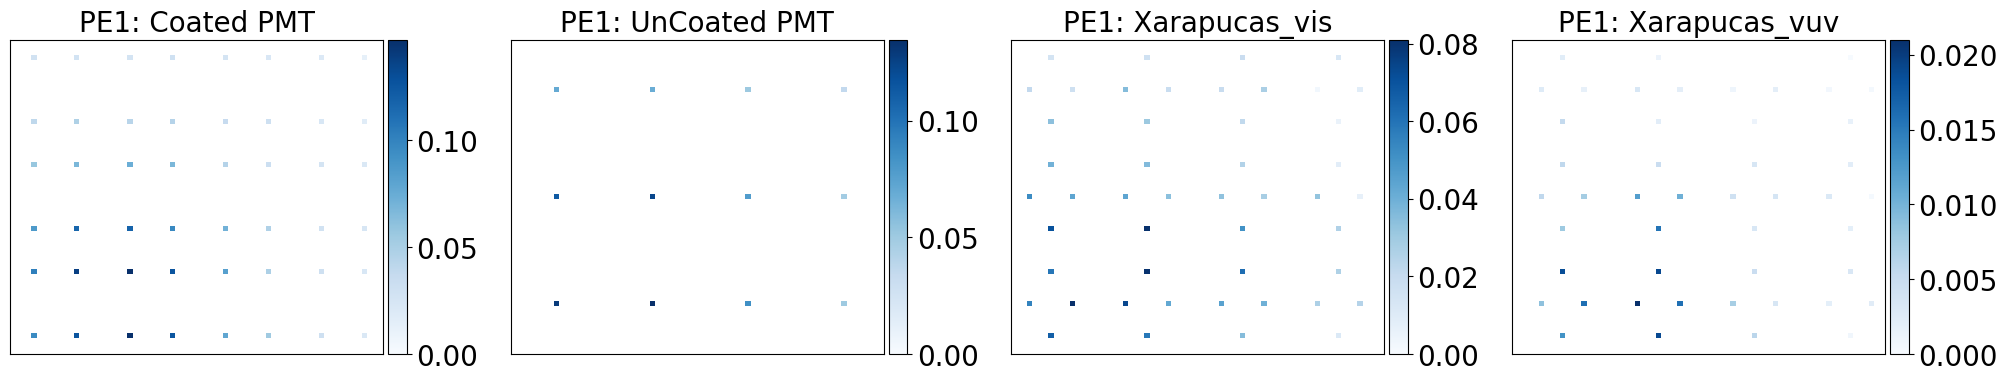

In [76]:
plot_image(image_onlype, event_idx, labels, groups, grid, figsize=(20, 20), show_colorbar= True )

### Creación y Normalización de y

In [73]:
dEpromx = np.array(dEpromx).flatten()
dEpromy = np.array(dEpromy).flatten()
dEpromz = np.array(dEpromz).flatten()
dEpromx = dEpromx.reshape(-1, 1)
dEpromy = dEpromy.reshape(-1, 1)
dEpromz = dEpromz.reshape(-1, 1)

In [74]:
dEpromx_abs = np.abs(dEpromx)

In [75]:
#y = np.column_stack((nuvT_c, dEpromx_f, dEpromy_f, dEpromz_f))
y = np.column_stack((dEpromx_abs, dEpromy, dEpromz))
y_np = ak.to_numpy(y)
print("Merged y_np:")
print(y_np)
print(np.shape(y_np))

Merged y_np:
[[ 162.67860374  -27.90349651  144.41268733]
 [ 163.11698776  144.53335678   52.83210869]
 [  39.46016702  -32.77356499  277.17001536]
 ...
 [  19.97918922  -62.58594057  437.16129081]
 [ 103.73808513 -188.22771817  141.55707222]
 [  83.00093107  119.99949047  110.47647264]]
(95417, 3)


In [76]:
from sklearn.preprocessing import MinMaxScaler

# For 3 entries (x,y,z):

columns_minus1_to_1 = [1]  # columns 0 and 1 to scale to [-1, 1]
columns_0_to_1 = [0,2]  # column 2 to scale to [0, 1]


# Initialize two scalers
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
scaler_minus1_1 = MinMaxScaler(feature_range=(-1, 1))

# Apply scaling for columns that need [0, 1]
y_np_scaled_0_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_0_1[:, columns_0_to_1] = scaler_0_1.fit_transform(y_np[:, columns_0_to_1])

# Apply scaling for columns that need [-1, 1]
y_np_scaled_minus1_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_minus1_1[:, columns_minus1_to_1] = scaler_minus1_1.fit_transform(y_np[:, columns_minus1_to_1])

# Combine the results (scaled data)
y_scaled_combined = np.copy(y_np)  # Start with the original data
y_scaled_combined[:, columns_0_to_1] = y_np_scaled_0_1[:, columns_0_to_1]
y_scaled_combined[:, columns_minus1_to_1] = y_np_scaled_minus1_1[:, columns_minus1_to_1]

# Print the scaled data
print("Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):")
print(y_scaled_combined)

Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):
[[ 0.80873809 -0.14012316  0.27928594]
 [ 0.81092672  0.72294332  0.09603867]
 [ 0.19357114 -0.16449842  0.54492544]
 ...
 [ 0.09631253 -0.31371283  0.86505844]
 [ 0.51447808 -0.94256452  0.27357203]
 [ 0.41094802  0.60014847  0.2113816 ]]


### Creación de train y test

In [77]:
train_size = int(np.floor(0.90*np.shape(y)[0]))
print("train_size:",train_size)
val_size = int(np.floor(0.05*np.shape(y)[0]) )
print("val_size:", val_size)
test_size = np.shape(y_scaled_combined)[0] - train_size - val_size 
print("test_size:",test_size)

train_size: 85875
val_size: 4770
test_size: 4772


In [78]:
# Para x
x_train = image_onlype[:train_size]
x_val   = image_onlype[train_size:train_size+val_size]
x_test  = image_onlype[-test_size:]

print('x_train:', x_train.shape)
print('x_val:', x_val.shape)
print('x_test:', x_test.shape)

# Para y
y_train = y_scaled_combined[:train_size]
y_val   = y_scaled_combined[train_size:train_size+val_size]
y_test  = y_scaled_combined[-test_size:]

print('y_train:', y_train.shape)
print('y_val:', y_val.shape)
print('y_test:', y_test.shape)

x_train: (85875, 59, 70, 4)
x_val: (4770, 59, 70, 4)
x_test: (4772, 59, 70, 4)
y_train: (85875, 3)
y_val: (4770, 3)
y_test: (4772, 3)


**only pmts**

In [110]:
# Para x
x_train_onlypmts = image_onlype_onlypmts[:train_size]
x_val_onlypmts  = image_onlype_onlypmts[train_size:train_size+val_size]
x_test_onlypmts  = image_onlype_onlypmts[-test_size:]

print('x_train:', x_train_onlypmts.shape)
print('x_val:', x_val_onlypmts.shape)
print('x_test:', x_test_onlypmts.shape)

x_train: (85875, 59, 70, 2)
x_val: (4770, 59, 70, 2)
x_test: (4772, 59, 70, 2)


**fcnn**

In [44]:
# Para x
x_train = pe_matrix[:train_size]
x_val   = pe_matrix[train_size:train_size+val_size]
x_test  = pe_matrix[-test_size:]

print('x_train:', x_train.shape)
print('x_val:', x_val.shape)
print('x_test:', x_test.shape)

x_train: (85875, 312)
x_val: (4770, 312)
x_test: (4772, 312)


### Definición de modelo

**4-Conv (4 Bloques convolucionales + 4 capas densas)**

In [17]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


# Input layer
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
input_layer = layers.Input(shape=input_shape)

# First convolutional block
model = layers.Conv2D(32, (3,3), padding='same')(input_layer)
model = layers.BatchNormalization()(model)
model = layers.LeakyReLU(negative_slope=0.1)(model)
model = layers.MaxPooling2D((2,2), padding='same')(model)

# Second convolutional block
model = layers.Conv2D(64, (3,3), padding='same')(model)
model = layers.BatchNormalization()(model)
model = layers.LeakyReLU(negative_slope=0.1)(model)
model = layers.MaxPooling2D((2,2), padding='same')(model)

# Third convolutional block
model = layers.Conv2D(128, (3,3), padding='same')(model)
model = layers.BatchNormalization()(model)
model = layers.LeakyReLU(negative_slope=0.1)(model)
model = layers.MaxPooling2D((2,2), padding='same')(model)

# Fourth convolutional block
model = layers.Conv2D(256, (3,3), padding='same')(model)
model = layers.BatchNormalization()(model)
model = layers.LeakyReLU(negative_slope=0.1)(model)
model = layers.MaxPooling2D((2,2), padding='same')(model)

# Flatten the output and pass through dense layers
model = layers.Flatten()(model)
model = layers.Dense(1024, activation='relu')(model)
model = layers.Dropout(0.3)(model)
model = layers.Dense(512, activation='relu')(model)
model = layers.Dropout(0.3)(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.3)(model)
model = layers.Dense(128, activation='relu')(model)
model = layers.Dropout(0.3)(model) 

# Output layer
output_layer = layers.Dense(3, activation='linear')(model)

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

2025-05-27 16:38:55.490014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-27 16:38:55.529553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-27 16:38:55.529976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [81]:
model.summary()

NameError: name 'model' is not defined

**ResNet-18**

In [178]:
import tensorflow as tf
from tensorflow.keras import layers, models


# Input layer
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])  # e.g., (57, 60, 16)
input = layers.Input(shape=input_shape)

# Initial convolution layer
x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Define the basic residual block (two 3x3 convolutions)
def basic_block(input, filters, stride=1, downsample=False):
    shortcut = input

    # First convolution in the block
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution in the block
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Downsample the shortcut if needed (to match dimensions)
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add shortcut to the main path
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ResNet-18 stages (2 blocks per stage)
# Stage 1: 2 blocks with 64 filters
x = basic_block(x, 64)
x = basic_block(x, 64)

# Stage 2: 2 blocks with 128 filters
x = basic_block(x, 128, stride=2, downsample=True)
x = basic_block(x, 128)

# Stage 3: 2 blocks with 256 filters
x = basic_block(x, 256, stride=1, downsample=True)  # Adjusted stride for smaller input (57x60)
x = basic_block(x, 256)

# Stage 4: 2 blocks with 512 filters
x = basic_block(x, 512, stride=1, downsample=True)  # Adjusted stride for smaller input
x = basic_block(x, 512)

# Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

# Dropout and Dense layer
x = layers.Dropout(0.4)(x)
output = layers.Dense(3)(x)  # 3 output units for regression task (adjust as needed)

# Create and compile the model
model37 = models.Model(inputs=input, outputs=output)
model37.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

### FCNN model

In [59]:
from tensorflow.keras import layers, models

# Asumiendo que x_train ya está definido
n_fotodetectores = x_train.shape[1]
output_size = 3  # Cambia si necesitas más o menos salidas

# Input layer
input = layers.Input(shape=(n_fotodetectores,))

# Fully connected feedforward layers
x = layers.Dense(2048, activation='relu')(input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu')(x)

# Output layer (sin activación porque es regresión)
output = layers.Dense(output_size)(x)

# Model definition and compilation
model_fcnn = models.Model(inputs=input, outputs=output)
model_fcnn.compile(optimizer= 'adam', loss='mse', metrics=['mse'])

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# Define the callbacks
weights_file = "/tmp/weights_nuvT.hdf5.keras"

checkpoint = ModelCheckpoint(
    weights_file, monitor='val_loss', verbose=0, save_best_only=True, mode='min'
)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

# Add all callbacks to the list
callbacks = [checkpoint, early_stopping, reduce_lr]

# Train the model
history = model_fcnn.fit(
    x_train,
    y_train,
    epochs=80,
    batch_size=16,
    callbacks=callbacks,
    validation_data=(x_val, y_val),
    verbose=1
)

# Load the best weights
model_fcnn.load_weights(weights_file)

Epoch 1/80
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 0.1593 - mse: 0.1593 - val_loss: 0.0133 - val_mse: 0.0133 - learning_rate: 0.0010
Epoch 2/80
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0115 - val_mse: 0.0115 - learning_rate: 0.0010
Epoch 3/80
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0107 - val_mse: 0.0107 - learning_rate: 0.0010
Epoch 4/80
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0085 - val_mse: 0.0085 - learning_rate: 0.0010
Epoch 5/80
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0145 - val_mse: 0.0145 - learning_rate: 0.0010
Epoch 6/80
5353/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128 - mse: 0.0128
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0096 - val_mse: 0.0096 - lear

In [20]:
model.save('/exp/sbnd/app/users/svidales/AI_nuvT/model_4conv_3d_50energ_pmts+xas.keras')

In [38]:
from tensorflow.keras.models import load_model

model111 = load_model('/exp/sbnd/app/users/svidales/AI_nuvT/model_4conv_3d_50energy_pmts+xas.keras')
model112 = load_model('/exp/sbnd/app/users/svidales/AI_nuvT/model_resnet18_3d_50energy_pmts+xas.keras')
model113 = load_model('/exp/sbnd/app/users/svidales/AI_nuvT/model_resnet18_3d_50energy_onlypmts.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 64 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [84]:
from tensorflow.keras.models import load_model
model113 = load_model('/exp/sbnd/app/users/svidales/AI_nuvT/model_resnet18_3d_50energy_onlypmts.keras')

In [86]:
y_val_pred = model113.predict(x_val_onlypmts)
y_test_pred = model113.predict(x_test_onlypmts)

109/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [49]:
import time

start_time = time.perf_counter()
y_test_pred = model_fcnn.predict(x_test)
end_time = time.perf_counter()

total_time_ms = (end_time - start_time) * 1000
print(f"Total inference time: {total_time_ms:.2f} ms")

# Optional: average time per sample
print(f"Avg time per sample: {total_time_ms / len(x_val):.2f} ms")


 93/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Total inference time: 304.76 ms
Avg time per sample: 0.06 ms


### Plotting the results

In [87]:
# Initialize a copy of the scaled combined data
y_val_pred_inverse= np.copy(y_val_pred)
y_test_pred_inverse= np.copy(y_test_pred)
y_val_inverse= np.copy(y_val)
y_test_inverse= np.copy(y_test)

# Inverse scaling for columns scaled to [0, 1]
y_val_pred_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_val_pred[:, columns_0_to_1])
y_test_pred_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_test_pred[:, columns_0_to_1])
y_val_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_val[:, columns_0_to_1])
y_test_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_test[:, columns_0_to_1])

# Inverse scaling for columns scaled to [-1, 1]
y_val_pred_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_val_pred[:, columns_minus1_to_1])
y_test_pred_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_test_pred[:, columns_minus1_to_1])
y_val_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_val[:, columns_minus1_to_1])
y_test_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_test[:, columns_minus1_to_1])

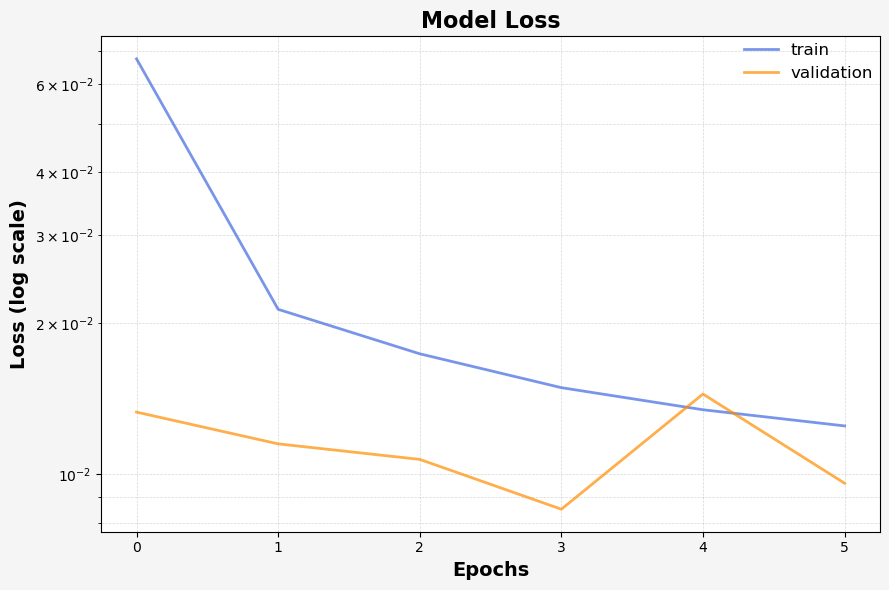

In [63]:
import matplotlib.pyplot as plt

# Access each model's history
model_history = history.history


# Plotting the validation loss for all models
plt.figure(figsize=(9, 6))

# Plot each model's validation loss with smoother lines, subtle markers, and clearer styling
# Training curves (using shades of blue and green)
plt.plot(model_history['loss'], label='train', color='royalblue', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Testing curves (using shades of orange and red)
plt.plot(model_history['val_loss'], label='validation', color='darkorange', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Enhance plot appearance
plt.yscale('log')  # Use logarithmic scale on y-axis
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Loss', fontsize=16, fontweight='bold')

# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()

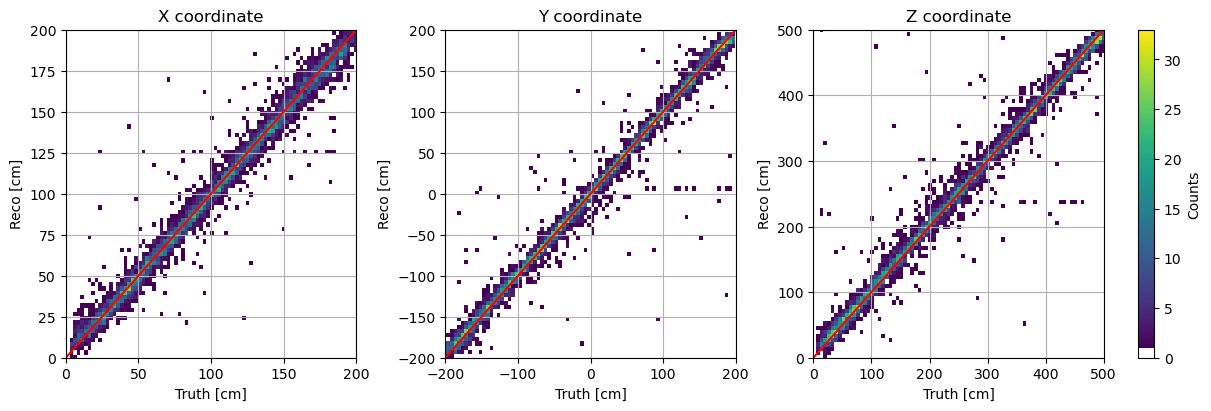

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Create a colormap that leaves 0 counts blank (white)
cmap = plt.get_cmap('viridis')

# Get histograms
hist1, xedges1, yedges1 = np.histogram2d(
    y_test_inverse[:, 0],
    y_test_pred_inverse[:, 0].flatten(),
    bins=(80, 80)
)
hist2, xedges2, yedges2 = np.histogram2d(
    y_test_inverse[:, 1],
    y_test_pred_inverse[:, 1].flatten(),
    bins=(80, 80)
)
hist3, xedges3, yedges3 = np.histogram2d(
    y_test_inverse[:, 2],
    y_test_pred_inverse[:, 2].flatten(),
    bins=(80, 80)
)

# Mask zeros
hist1 = np.ma.masked_equal(hist1, 0)
hist2 = np.ma.masked_equal(hist2, 0)
hist3 = np.ma.masked_equal(hist3, 0)

# Shared vmax
global_max = max(np.max(hist1), np.max(hist2), np.max(hist3))

# Create plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
#fig.suptitle("reco vs Truth comparison", fontsize=16)

# --- Coordenada X ---
im1 = axs[0].pcolormesh(xedges1, yedges1, hist1.T, cmap=cmap, shading='auto', vmin=1, vmax=global_max)
axs[0].set_title("X coordinate")
axs[0].grid()
axs[0].plot([0, 200], [0, 200], 'r')
axs[0].set_xlim([0, 200])
axs[0].set_ylim([0, 200])
axs[0].set_ylabel('Reco [cm]')
axs[0].set_xlabel('Truth [cm]')

# --- Coordenada Y ---
im2 = axs[1].pcolormesh(xedges2, yedges2, hist2.T, cmap=cmap, shading='auto', vmin=1, vmax=global_max)
axs[1].set_title("Y coordinate")
axs[1].grid()
axs[1].plot([-200, 200], [-200, 200], 'r')
axs[1].set_xlim([-200, 200])
axs[1].set_ylim([-200, 200])
axs[1].set_ylabel('Reco [cm]')
axs[1].set_xlabel('Truth [cm]')

# --- Coordenada Z ---
im3 = axs[2].pcolormesh(xedges3, yedges3, hist3.T, cmap=cmap, shading='auto', vmin=1, vmax=global_max)
axs[2].set_title("Z coordinate")
axs[2].grid()
axs[2].plot([0, 500], [0, 500], 'r')
axs[2].set_xlim([0, 500])
axs[2].set_ylim([0, 500])
axs[2].set_ylabel('Reco [cm]')
axs[2].set_xlabel('Truth [cm]')

# Shared colorbar
cbar = fig.colorbar(im3, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Counts')
cbar.set_ticks(np.arange(0, global_max + 1, 5))

plt.show()


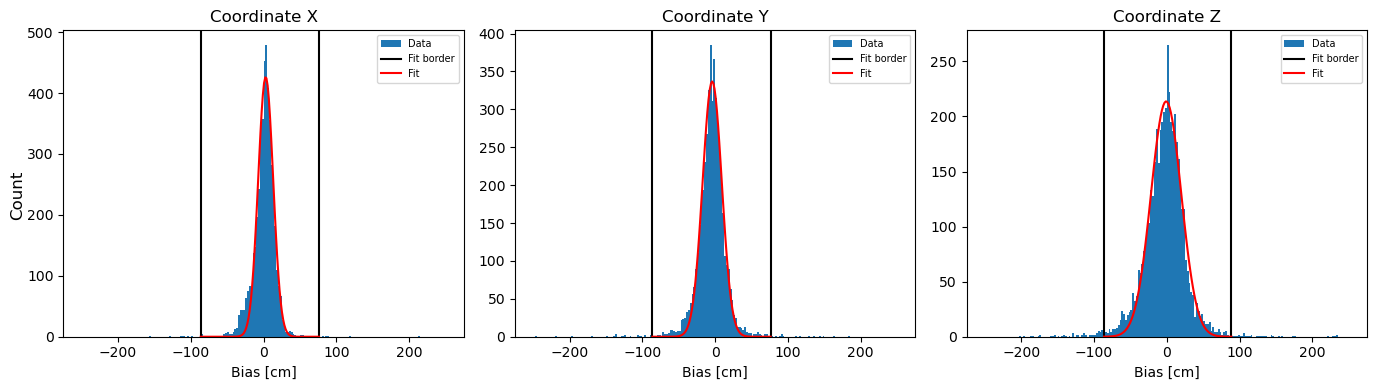

Bias Adjustment variables
------------------
Mean X = 2.99
Sigma X = 10.30
------------------
Mean Y = -4.09
Sigma Y = 13.17
------------------
Mean Z = -0.95
Sigma Z = 20.83
------------------


In [65]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value

diffX = y_test_pred_inverse[:, 0].flatten() - y_test_inverse[:, 0]
diffY = y_test_pred_inverse[:, 1].flatten() - y_test_inverse[:, 1]
diffZ = y_test_pred_inverse[:, 2].flatten() - y_test_inverse[:, 2]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin, hist_range):
    counts, bins, patches = axs[index].hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Fit border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    bounds = ([0, -np.inf, 1e-6], [np.inf, np.inf, np.inf])  # sigma > 0
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=bounds)
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Fit')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Call the function with updated range for nuvT

popt_X = fit_and_plot_hist(diffX, axs, 0, 'X', 65, 130, hist_range=[-250, 250])
popt_Y = fit_and_plot_hist(diffY, axs, 1, 'Y', 65, 130, hist_range=[-250, 250])
popt_Z = fit_and_plot_hist(diffZ, axs, 2, 'Z', 65, 135, hist_range=[-250, 250])


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


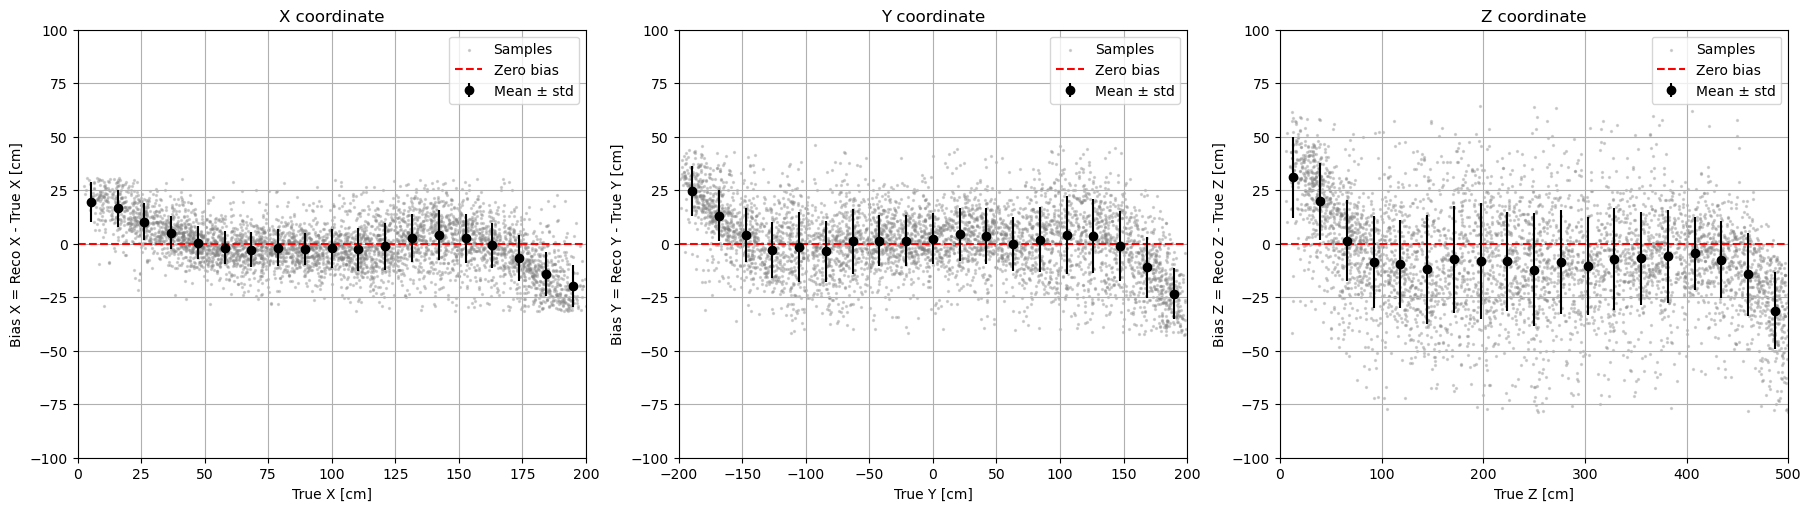

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
truth_coords = [y_test_inverse[:, 0], y_test_inverse[:, 1], y_test_inverse[:, 2]]
diff_coords = [diffX.flatten(), diffY.flatten(), diffZ.flatten()]

labels = ['X', 'Y', 'Z']
xlims = [(0, 200), (-200, 200), (0, 500)]

# Crear figura
fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for i in range(3):
    truth = truth_coords[i]
    diff = diff_coords[i]
    label = labels[i]
    xlim = xlims[i]

    # Filtrar outliers: mantener solo valores dentro de 3 sigmas
    mask = np.abs(diff - np.median(diff)) < 2 * np.std(diff)
    truth_filtered = truth[mask]
    diff_filtered = diff[mask]

    axs[i].scatter(truth_filtered, diff_filtered, s=2, alpha=0.3, color='gray', label='Samples')
    axs[i].axhline(0, color='red', linestyle='--', label='Zero bias')
    axs[i].set_xlabel(f'True {label} [cm]')
    axs[i].set_ylabel(f'Bias {label} = Reco {label} - True {label} [cm]')
    axs[i].set_title(f'{label} coordinate')
    axs[i].grid(True)

    # Binning
    bins = np.linspace(xlim[0], xlim[1], 20)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    digitized = np.digitize(truth_filtered, bins)
    bin_means = [diff_filtered[digitized == j].mean() if np.any(digitized == j) else np.nan for j in range(1, len(bins))]
    bin_stds = [diff_filtered[digitized == j].std() if np.any(digitized == j) else np.nan for j in range(1, len(bins))]

    axs[i].errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', label='Mean ± std')
    axs[i].set_xlim(xlim)
    axs[i].set_ylim([-100, 100])
    axs[i].legend()

plt.show()

In [89]:
# coated_pmt, uncoated_pmt, xarap_vis (uncoated), xarap_vuv (coated)
# Assuming 'data' has shape (5767, 59, 70, 4)
# Sum channels: (0 + 2) and (1 + 3)
coated_sum = x_test[..., 0]
uncoated_sum = x_test[..., 1]

# Sum across spatial dimensions (59, 70)
coated_sum_total = np.sum(coated_sum, axis=(1, 2))  
uncoated_sum_total = np.sum(uncoated_sum, axis=(1, 2))  

nu = uncoated_sum_total / coated_sum_total

print(nu)
print(y_val_inverse[:,0])
print(y_val[:,0])

[0.26138606 0.30045002 0.44123451 ... 0.40083041 0.16076477 0.22508511]
[ 16.56518698 145.68864103  23.95300947 ... 105.37792251  81.12644086
 169.6680114 ]
[0.07926816 0.72391585 0.1161518  ... 0.52266495 0.40158964 0.84363264]


/tmp/ipykernel_1972/475768866.py:11: RuntimeWarning: invalid value encountered in divide
  nu = uncoated_sum_total / coated_sum_total


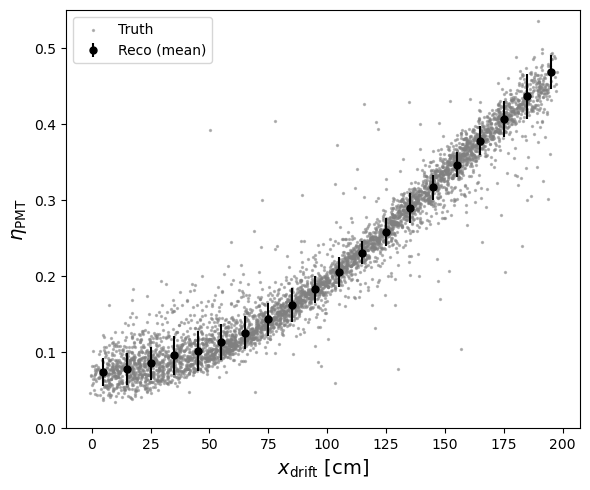

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Supuestos:
# - x_truth: valores reales de x
# - x_pred: valores predichos por la red
# - nu: variable auxiliar

pred = y_test_pred_inverse[:,0]
truth = y_test_inverse[:,0]

# Aplicar el mapeo: 200 → 0, 190 → 10, ..., 0 → 200
x_mapped = 200 - truth

# Parámetros de binning
num_bins = 20
bins = np.linspace(0, 200, num_bins + 1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
mapped_bin_centers = 200 - bin_centers  # para que coincidan con x_mapped

# Inicializar listas
bin_means = []
bin_stds = []
valid_bin_centers = []

# Clipping de nu para evitar outliers
lower_clip = 0.0
upper_clip = 1.5
min_points = 10

# Calcular medias y desviaciones estándar de nu en cada bin de x_pred
for i in range(num_bins):
    in_bin = (pred >= bins[i]) & (pred < bins[i + 1])
    values_in_bin = nu[in_bin]

    # Clipping
    values_in_bin = values_in_bin[(values_in_bin >= lower_clip) & (values_in_bin <= upper_clip)]

    if len(values_in_bin) >= min_points:
        bin_means.append(np.mean(values_in_bin))
        bin_stds.append(np.std(values_in_bin))
        valid_bin_centers.append(mapped_bin_centers[i])

# Convertir a arrays
bin_means = np.array(bin_means)
bin_stds = np.array(bin_stds)
valid_bin_centers = np.array(valid_bin_centers)

# Plot
plt.figure(figsize=(6, 5))

# 1) Nube de puntos en sistema invertido
plt.scatter(x_mapped, nu, color='gray', s=2, alpha=0.5, label='Truth')

# 2) Curva con barras de error
plt.errorbar(valid_bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', label='Reco (mean)', markersize=5)

# Etiquetas y estilo
plt.xlabel(r'$x_{\mathrm{drift}}$ [cm]', fontsize=14)
plt.ylabel(r'$\eta_{\mathrm{PMT}}$', fontsize=14)
plt.ylim(0, 0.55)
plt.legend()
plt.tight_layout()
plt.show()

Depuración: Puntos por bin antes y después del clipping
Bin 0 (centro: 5.0): 42 puntos antes, 41 después
Bin 1 (centro: 15.0): 195 puntos antes, 193 después
Bin 2 (centro: 25.0): 253 puntos antes, 253 después
Bin 3 (centro: 35.0): 260 puntos antes, 260 después
Bin 4 (centro: 45.0): 297 puntos antes, 297 después
Bin 5 (centro: 55.0): 265 puntos antes, 265 después
Bin 6 (centro: 65.0): 236 puntos antes, 236 después
Bin 7 (centro: 75.0): 261 puntos antes, 261 después
Bin 8 (centro: 85.0): 264 puntos antes, 264 después
Bin 9 (centro: 95.0): 238 puntos antes, 238 después
Bin 10 (centro: 105.0): 258 puntos antes, 258 después
Bin 11 (centro: 115.0): 267 puntos antes, 267 después
Bin 12 (centro: 125.0): 274 puntos antes, 261 después
Bin 13 (centro: 135.0): 268 puntos antes, 268 después
Bin 14 (centro: 145.0): 261 puntos antes, 261 después
Bin 15 (centro: 155.0): 237 puntos antes, 237 después
Bin 16 (centro: 165.0): 250 puntos antes, 250 después
Bin 17 (centro: 175.0): 284 puntos antes, 284 des

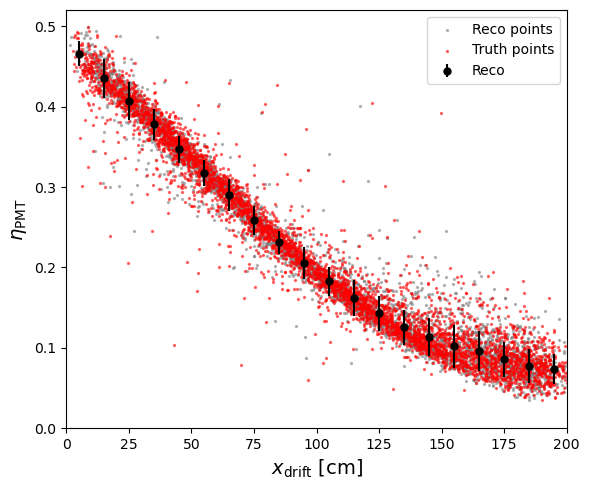

In [118]:
import numpy as np
import matplotlib.pyplot as plt


# Parámetros de binning
num_bins = 20
bins = np.linspace(0, 200, num_bins + 1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Inicializar listas
bin_means = []
bin_stds = []
valid_bin_centers = []

# Clipping de nu
lower_clip = 0.0
upper_clip = 0.5
min_points = 1

# Depuración: Contar puntos por bin
print("Depuración: Puntos por bin antes y después del clipping")
for i in range(num_bins):
    # Seleccionar puntos en el bin
    in_bin = (pred >= bins[i]) & (pred < bins[i + 1])
    values_in_bin = nu[in_bin]
    num_points_before = len(values_in_bin)
    
    # Clipping
    values_in_bin = values_in_bin[(values_in_bin >= lower_clip) & (values_in_bin <= upper_clip)]
    num_points_after = len(values_in_bin)
    
    print(f"Bin {i} (centro: {bin_centers[i]:.1f}): {num_points_before} puntos antes, {num_points_after} después")
    
    if num_points_after >= min_points:
        bin_means.append(np.mean(values_in_bin))
        bin_stds.append(np.std(values_in_bin))
        valid_bin_centers.append(bin_centers[i])

# Convertir a arrays
bin_means = np.array(bin_means)
bin_stds = np.array(bin_stds)
valid_bin_centers = np.array(valid_bin_centers)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(pred, nu, color='gray', s=2, alpha=0.5, label='Reco points')
plt.scatter(truth, nu, color='red', s=2, alpha=0.5, label='Truth points')
plt.errorbar(valid_bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', label='Reco', markersize=5)
plt.xlabel(r'$x_{\mathrm{drift}}$ [cm]', fontsize=14)
plt.ylabel(r'$\eta_{\mathrm{PMT}}$', fontsize=14)
plt.ylim(0, 0.52)
plt.xlim(0,200)
plt.legend()
plt.tight_layout()
plt.show()

### Post-calibration 4-conv

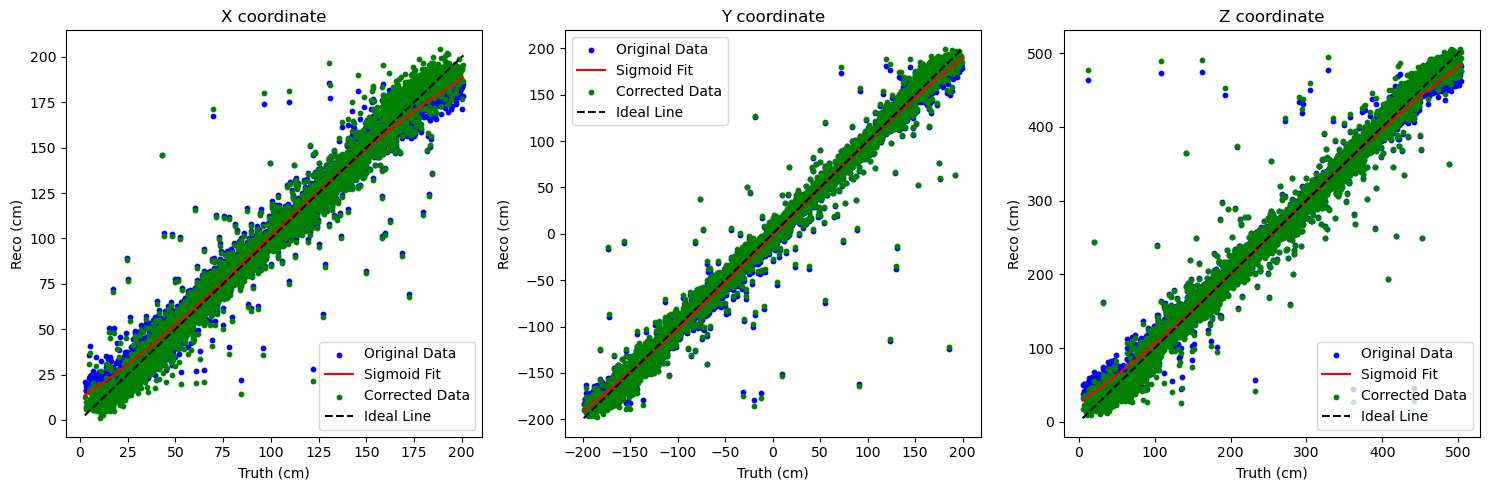

Orden original preservado. Shape de los datos corregidos: (4772, 3)
parameters: [ 9.01865628e+02  4.46446550e-03  2.61559083e+02 -1.88865294e+02]


In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Definir una función no lineal (sigmoide) para modelar la relación Reco = f(Truth)
def sigmoid(x, L, k, x0, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Datos de ejemplo (reemplaza con tus datos reales de shape (5287, 3))
truth = y_test_inverse
reco = y_test_pred_inverse

# Crear figuras para visualizar las 3 coordenadas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
coord_names = ['X coordinate', 'Y coordinate', 'Z coordinate']

# Almacenar los datos corregidos manteniendo el orden original
corrected_reco_all = np.zeros_like(reco)

for i in range(3):  # Iterar sobre las coordenadas X, Y, Z
    truth_coord = truth[:, i]
    reco_coord = reco[:, i]

    # Ajustar la función sigmoide a los datos (sin ordenar)
    p0 = [max(reco_coord), 0.1, np.median(truth_coord), min(reco_coord)]  # [L, k, x0, b]
    try:
        params, _ = curve_fit(sigmoid, truth_coord, reco_coord, p0, maxfev=5000)
    except RuntimeError:
        print(f"No se pudo ajustar la coordenada {coord_names[i]}. Usando una aproximación lineal.")
        params = [1, 0, 0, 0]  # Fallback a una relación lineal si el ajuste falla

    L, k, x0, b = params

    # Generar puntos para la curva ajustada (para visualización e inversa)
    truth_range = np.linspace(min(truth_coord), max(truth_coord), 1000)
    reco_fitted = sigmoid(truth_range, L, k, x0, b)

    # Crear una interpolación numérica para la inversa (Reco -> Truth)
    # Esto evita la necesidad de ordenar los datos
    inverse_interp = interp1d(reco_fitted, truth_range, bounds_error=False, fill_value="extrapolate")

    # Aplicar la corrección inversa a los datos originales
    corrected_reco = inverse_interp(reco_coord)
    corrected_reco_all[:, i] = corrected_reco

    # Visualización
    axes[i].scatter(truth_coord, reco_coord, label='Original Data', color='blue', s=10)
    axes[i].plot(truth_range, reco_fitted, label='Sigmoid Fit', color='red')
    axes[i].scatter(truth_coord, corrected_reco, label='Corrected Data', color='green', s=10)
    axes[i].plot(truth_range, truth_range, '--', label='Ideal Line', color='black')
    axes[i].set_xlabel('Truth (cm)')
    axes[i].set_ylabel('Reco (cm)')
    axes[i].set_title(coord_names[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

# Verificar que el orden no se ha perdido
print("Orden original preservado. Shape de los datos corregidos:", corrected_reco_all.shape)
print("parameters:", params)

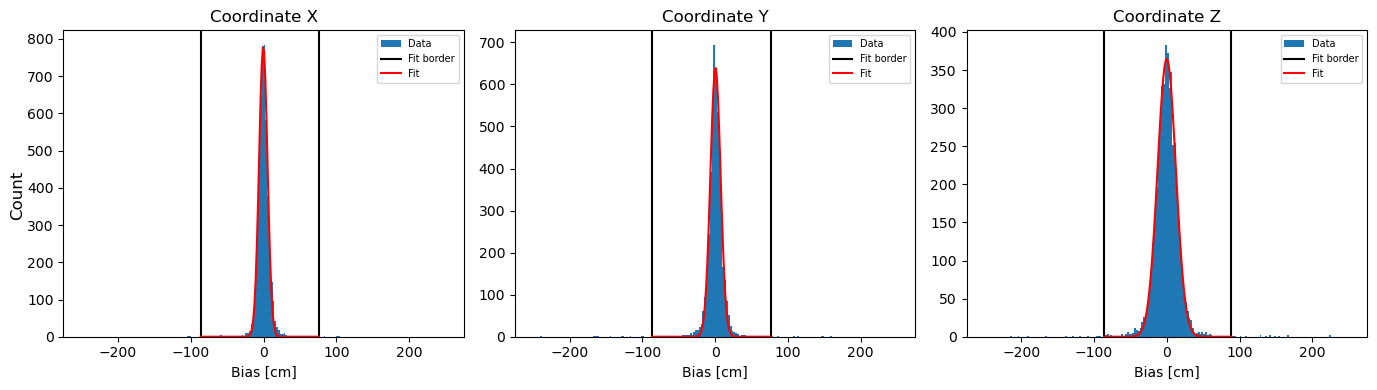

Bias Adjustment variables
------------------
Mean X = -0.33
Sigma X = 5.78
------------------
Mean Y = 0.42
Sigma Y = 6.98
------------------
Mean Z = -0.17
Sigma Z = 12.55
------------------


In [171]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value

diffX =  corrected_reco_all[:,0].flatten() - y_test_inverse[:, 0]
diffY =  corrected_reco_all[:,1].flatten() - y_test_inverse[:, 1]
diffZ =  corrected_reco_all[:,2].flatten() - y_test_inverse[:, 2]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin, hist_range):
    counts, bins, patches = axs[index].hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Fit border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    bounds = ([0, -np.inf, 1e-6], [np.inf, np.inf, np.inf])  # sigma > 0
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=bounds)
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Fit')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Call the function with updated range for nuvT

popt_X = fit_and_plot_hist(diffX, axs, 0, 'X', 65, 130, hist_range=[-250, 250])
popt_Y = fit_and_plot_hist(diffY, axs, 1, 'Y', 65, 130, hist_range=[-250, 250])
popt_Z = fit_and_plot_hist(diffZ, axs, 2, 'Z', 65, 135, hist_range=[-250, 250])


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


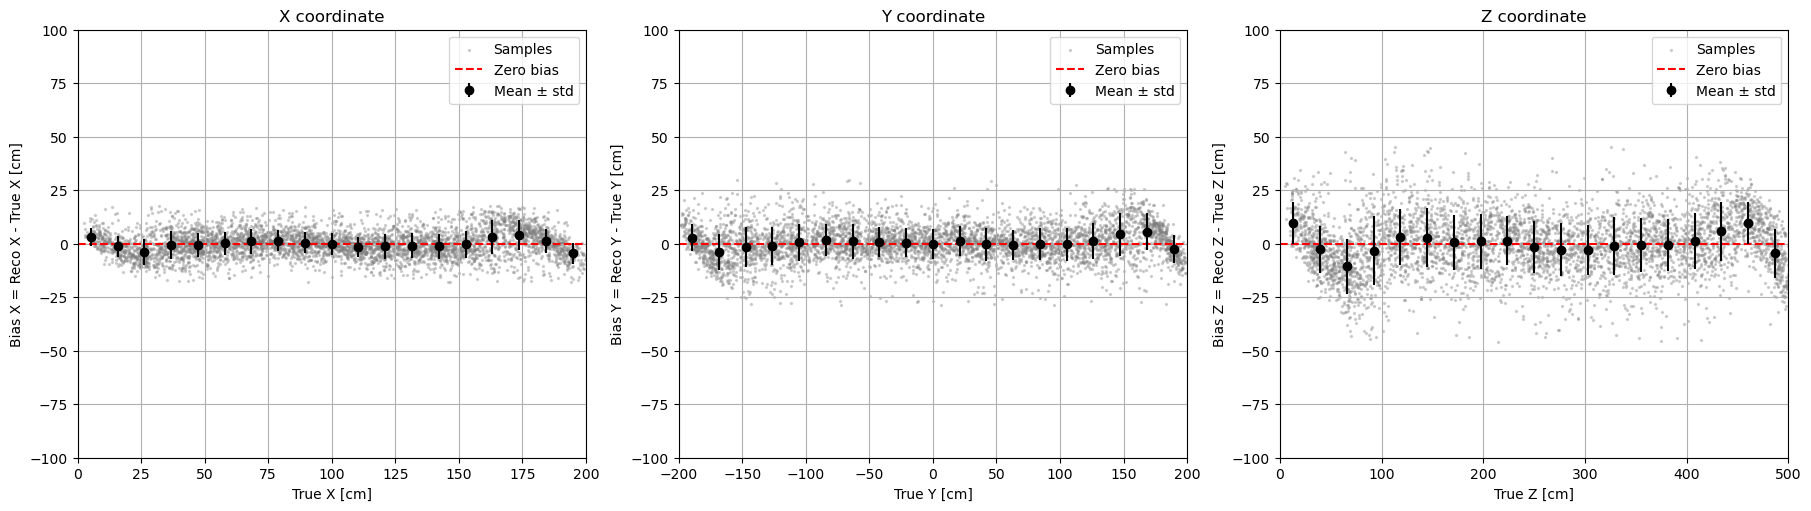

In [172]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
truth_coords = [y_test_inverse[:, 0], y_test_inverse[:, 1], y_test_inverse[:, 2]]
diff_coords = [diffX.flatten(), diffY.flatten(), diffZ.flatten()]

labels = ['X', 'Y', 'Z']
xlims = [(0, 200), (-200, 200), (0, 500)]

# Crear figura
fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for i in range(3):
    truth = truth_coords[i]
    diff = diff_coords[i]
    label = labels[i]
    xlim = xlims[i]

    # Filtrar outliers: mantener solo valores dentro de 3 sigmas
    mask = np.abs(diff - np.median(diff)) < 2 * np.std(diff)
    truth_filtered = truth[mask]
    diff_filtered = diff[mask]

    axs[i].scatter(truth_filtered, diff_filtered, s=2, alpha=0.3, color='gray', label='Samples')
    axs[i].axhline(0, color='red', linestyle='--', label='Zero bias')
    axs[i].set_xlabel(f'True {label} [cm]')
    axs[i].set_ylabel(f'Bias {label} = Reco {label} - True {label} [cm]')
    axs[i].set_title(f'{label} coordinate')
    axs[i].grid(True)

    # Binning
    bins = np.linspace(xlim[0], xlim[1], 20)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    digitized = np.digitize(truth_filtered, bins)
    bin_means = [diff_filtered[digitized == j].mean() if np.any(digitized == j) else np.nan for j in range(1, len(bins))]
    bin_stds = [diff_filtered[digitized == j].std() if np.any(digitized == j) else np.nan for j in range(1, len(bins))]

    axs[i].errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', label='Mean ± std')
    axs[i].set_xlim(xlim)
    axs[i].set_ylim([-100, 100])
    axs[i].legend()

plt.show()